# Explore here

In [ ]:
testing push


Processing: Aquifer_Auser.csv
Target column: Depth_to_Groundwater_SAL
✅ SARIMA config (1,1,1)(1,1,1,12) MAE: 0.9377
✅ SARIMA config (0,1,1)(0,1,1,12) MAE: 0.9230
✅ SARIMA config (1,1,0)(1,1,0,12) MAE: 0.7911
✅ Processed | MAE: 0.4281 | R²: -0.0315

Processing: Aquifer_Doganella.csv
Target column: Depth_to_Groundwater_Pozzo_1
✅ SARIMA config (1,1,1)(1,1,1,12) MAE: 8.1231
✅ SARIMA config (0,1,1)(0,1,1,12) MAE: 8.0307
✅ Processed | MAE: 6.7321 | R²: -1.6559

Processing: Aquifer_Luco.csv
Target column: Depth_to_Groundwater_Podere_Casetta
✅ SARIMA config (1,1,1)(1,1,1,12) MAE: 0.2021
✅ SARIMA config (1,1,0)(1,1,0,12) MAE: 0.0649
✅ Processed | MAE: 0.0939 | R²: -1.2258

Processing: Aquifer_Petrignano.csv
Target column: Depth_to_Groundwater_P24
✅ SARIMA config (1,1,1)(1,1,1,12) MAE: 0.7399
✅ SARIMA config (0,1,1)(0,1,1,12) MAE: 0.7266
✅ SARIMA config (1,0,1)(1,0,1,12) MAE: 0.6128
✅ Processed | MAE: 0.7162 | R²: -3.9250

Processing: Water_Spring_Amiata.csv
Target column: Flow_Rate_Bugnano
✅ S

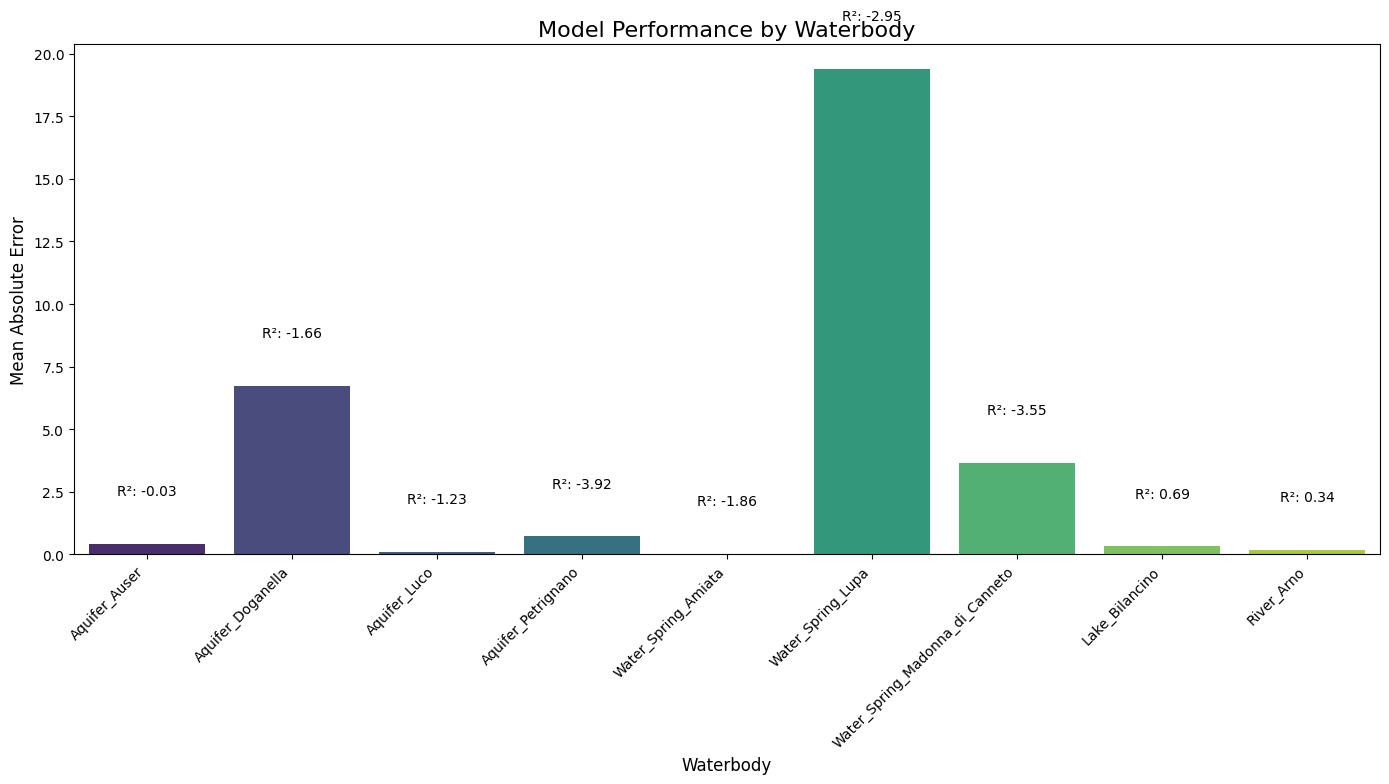

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import traceback

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Create directory structure
os.makedirs('eda_plots', exist_ok=True)
os.makedirs('submissions', exist_ok=True)
os.makedirs('models', exist_ok=True)

def process_waterbody(file_path, target_column):
    """Process any waterbody dataset using our pipeline"""
    print(f"\n{'='*50}")
    print(f"Processing: {file_path}")
    print(f"Target column: {target_column}")
    print(f"{'='*50}")
    
    try:
        # Load data
        wb_df = pd.read_csv(file_path)
        
        # Validate target column
        if target_column not in wb_df.columns:
            # Try to find similar column
            possible_targets = [col for col in wb_df.columns 
                              if any(kw in col.lower() for kw in ['depth', 'flow', 'level', 'hydrometry'])]
            if possible_targets:
                target_column = possible_targets[0]
                print(f"⚠️ Using alternative target: {target_column}")
            else:
                print(f"⚠️ Target column not found. Using first numeric column")
                numeric_cols = wb_df.select_dtypes(include=np.number).columns
                if len(numeric_cols) > 1:
                    target_column = numeric_cols[1]
        
        # Select relevant columns
        feature_columns = [col for col in wb_df.columns 
                          if col != 'Date' and col != target_column and 
                          any(kw in col.lower() for kw in ['rainfall', 'temperature', 'hydrometry'])]
        wb_df = wb_df[['Date', target_column] + feature_columns].copy()
        wb_df = wb_df.dropna(subset=[target_column])
        
        if len(wb_df) < 100:
            print(f"⚠️ Insufficient data points: {len(wb_df)}")
            return np.nan, np.nan
        
        # Preprocessing
        wb_df['Date'] = pd.to_datetime(wb_df['Date'], format='%d/%m/%Y', errors='coerce')
        wb_df = wb_df.dropna(subset=['Date'])
        wb_df['day_of_year'] = wb_df['Date'].dt.dayofyear
        wb_df['month'] = wb_df['Date'].dt.month
        wb_df['year'] = wb_df['Date'].dt.year
        
        # Feature engineering
        for col in feature_columns:
            # Lag features
            for lag in [7, 30, 90]:
                wb_df[f'{col}_lag_{lag}'] = wb_df[col].shift(lag)
            
            # Rolling features
            wb_df[f'{col}_rolling_7'] = wb_df[col].rolling(window=7).mean()
            wb_df[f'{col}_rolling_30'] = wb_df[col].rolling(window=30).mean()
        
        # Hydrological year features
        wb_df['hydrological_year'] = wb_df['Date'].apply(
            lambda x: x.year if x.month >= 10 else x.year - 1
        )
        
        # Fill missing values
        wb_df.fillna(method='ffill', inplace=True)
        wb_df.fillna(0, inplace=True)
        
        # Dynamic test size based on data length
        total_days = (wb_df['Date'].max() - wb_df['Date'].min()).days
        if total_days < 365:  # Less than 1 year
            test_size = int(len(wb_df) * 0.2)  # 20% test size
        else:
            test_size = 180  # 6 months
        
        # Train-test split
        test_cutoff = wb_df['Date'].max() - pd.DateOffset(days=test_size)
        train = wb_df[wb_df['Date'] < test_cutoff].dropna()
        test = wb_df[wb_df['Date'] >= test_cutoff].dropna()
        
        if len(train) < 100 or len(test) < 30:
            print(f"⚠️ Insufficient data for modeling: {len(train)} train, {len(test)} test")
            return np.nan, np.nan
        
        # Model setup
        features = [col for col in wb_df.columns 
                   if col not in ['Date', target_column] and not col.startswith('hydrological')]
        
        # --- EDA ---
        waterbody_name = os.path.basename(file_path).split('.')[0]
        eda_dir = f'eda_plots/{waterbody_name}'
        os.makedirs(eda_dir, exist_ok=True)
        
        # --- Modeling ---
        # Time Series Model (Manual SARIMA)
        try:
            # Try multiple SARIMA configurations
            best_mae = float('inf')
            best_forecast = None
            best_model = None
            
            # Common SARIMA configurations to try
            configs = [
                (1, 1, 1, 1, 1, 1, 12),  # (p,d,q,P,D,Q,s)
                (0, 1, 1, 0, 1, 1, 12),
                (1, 1, 0, 1, 1, 0, 12),
                (1, 0, 1, 1, 0, 1, 12),
                (0, 1, 0, 0, 1, 0, 12)
            ]
            
            for order in configs:
                p, d, q, P, D, Q, s = order
                try:
                    ts_model = SARIMAX(
                        train[target_column],
                        order=(p, d, q),
                        seasonal_order=(P, D, Q, s)
                    ).fit(disp=False)
                    ts_forecast = ts_model.forecast(steps=len(test))
                    ts_mae = mean_absolute_error(test[target_column], ts_forecast)
                    
                    if ts_mae < best_mae:
                        best_mae = ts_mae
                        best_forecast = ts_forecast
                        best_model = ts_model
                        print(f"✅ SARIMA config ({p},{d},{q})({P},{D},{Q},{s}) MAE: {ts_mae:.4f}")
                except:
                    continue
            
            if best_model is None:
                print("⚠️ All SARIMA configs failed. Using mean forecast")
                best_forecast = np.full(len(test), train[target_column].mean())
            else:
                ts_forecast = best_forecast
                ts_model = best_model
        except Exception as e:
            print(f"⚠️ SARIMA modeling failed: {str(e)}")
            ts_forecast = np.full(len(test), train[target_column].mean())
        
        # Supervised Model (Random Forest with feature selection)
        try:
            X_train = train[features]
            y_train = train[target_column]
            X_test = test[features]
            
            rf = RandomForestRegressor(n_estimators=200, random_state=42)
            rf.fit(X_train, y_train)
            rf_pred = rf.predict(X_test)
        except:
            rf_pred = np.full(len(test), train[target_column].mean())
        
        # Weighted ensemble based on model performance
        try:
            ts_mae = mean_absolute_error(test[target_column], ts_forecast)
            rf_mae = mean_absolute_error(test[target_column], rf_pred)
            
            # Calculate weights inversely proportional to MAE
            ts_weight = 1 / (ts_mae + 1e-5)
            rf_weight = 1 / (rf_mae + 1e-5)
            total_weight = ts_weight + rf_weight
            
            final_pred = (ts_forecast * (ts_weight/total_weight)) + (rf_pred * (rf_weight/total_weight))
        except:
            # Fallback to simple average
            final_pred = (ts_forecast + rf_pred) / 2
        
        mae = mean_absolute_error(test[target_column], final_pred)
        r2 = r2_score(test[target_column], final_pred)
        
        # Generate submission file
        submission = pd.DataFrame({
            'date': test['Date'],
            'water_level': final_pred
        })
        submission.to_csv(f'submissions/{waterbody_name}_submission.csv', index=False)
        
        # Enhanced forecast visualization
        plt.figure(figsize=(16, 8))
        plt.plot(train['Date'], train[target_column], label='Training Data', alpha=0.7)
        plt.plot(test['Date'], test[target_column], label='Actual', color='#2c7bb6', linewidth=2)
        plt.plot(test['Date'], final_pred, label='Ensemble Forecast', color='#d7191c', linewidth=2)
        
        # Add confidence interval if SARIMA succeeded
        try:
            forecast_obj = ts_model.get_forecast(steps=len(test))
            conf_int = forecast_obj.conf_int()
            plt.fill_between(test['Date'], 
                             conf_int.iloc[:, 0], 
                             conf_int.iloc[:, 1], 
                             color='#fdae61', alpha=0.3, 
                             label='95% Confidence Interval')
        except:
            pass
        
        plt.annotate(f'MAE: {mae:.2f}', 
                     xy=(test['Date'].iloc[len(test)//3], 
                     test[target_column].min() + 0.1*(test[target_column].max()-test[target_column].min())),
                     fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
        
        plt.title(f'{waterbody_name}: {target_column}\nTest Period: {test["Date"].min().date()} to {test["Date"].max().date()}', fontsize=14)
        plt.ylabel('Value', fontsize=12)
        plt.xlabel('Date', fontsize=12)
        plt.legend()
        plt.grid(alpha=0.2)
        plt.tight_layout()
        plt.savefig(f'{eda_dir}/forecast_validation.png', dpi=300)
        plt.close()
        
        print(f"✅ Processed | MAE: {mae:.4f} | R²: {r2:.4f}")
        return mae, r2
        
    except Exception as e:
        print(f"❌ Processing failed: {str(e)}")
        traceback.print_exc()
        return np.nan, np.nan

# Competition datasets with verified targets
waterbodies = [
    ('Aquifer_Auser.csv', 'Depth_to_Groundwater_SAL'),
    ('Aquifer_Doganella.csv', 'Depth_to_Groundwater_Pozzo_1'),
    ('Aquifer_Luco.csv', 'Depth_to_Groundwater_Podere_Casetta'),
    ('Aquifer_Petrignano.csv', 'Depth_to_Groundwater_P24'),
    ('Water_Spring_Amiata.csv', 'Flow_Rate_Bugnano'),
    ('Water_Spring_Lupa.csv', 'Flow_Rate_Lupa'),
    ('Water_Spring_Madonna_di_Canneto.csv', 'Flow_Rate_Madonna_di_Canneto'),
    ('Lake_Bilancino.csv', 'Lake_Level'),
    ('River_Arno.csv', 'Hydrometry_Nave_di_Rosano')
]

# Process all waterbodies
results = []
for file, target in waterbodies:
    if not os.path.exists(file):
        print(f"⚠️ File not found: {file}")
        continue
        
    mae, r2 = process_waterbody(file, target)
    results.append({
        'Waterbody': os.path.basename(file).split('.')[0],
        'MAE': mae,
        'R2': r2  # Use R2 instead of R²
    })

# Generate final report
results_df = pd.DataFrame(results)
print("\n🏆 Final Performance Report:")
print(results_df)
results_df.to_csv('competition_results.csv', index=False)

# Final summary visualization
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=results_df, x='Waterbody', y='MAE', palette='viridis')
plt.title('Model Performance by Waterbody', fontsize=16)
plt.ylabel('Mean Absolute Error', fontsize=12)
plt.xlabel('Waterbody', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Get y-axis limits for text positioning
max_mae = results_df['MAE'].max()
min_mae = results_df['MAE'].min()
offset = 0.1 * (max_mae - min_mae) if not np.isnan(max_mae) and not np.isnan(min_mae) else 0.5

# Add R² values as text
for i, row in enumerate(results_df.itertuples()):
    if not np.isnan(row.R2):
        # Position text above bar with smart offset
        text_y = row.MAE + offset
        # Format R² value with 2 decimals
        r2_text = f"R²: {row.R2:.2f}"
        ax.text(i, text_y, r2_text, ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('overall_performance.png', dpi=150)
plt.show()